# Digits Recognition Case Study - Support Vector Machine (SVM) Classification

A classic problem in the field of pattern recognition is that of handwritten digit recognition. Here we have images of handwritten digits ranging from 0-9 written by various people in boxes of a specific size - similar to the application forms in banks and universities. The goal is to develop a model that can correctly identify the digit (between 0-9) written in an image.

## Objectives

You need to develop a model using **Support Vector Machine** which should correctly classify the handwritten digits from 0-9 based on the pixel values given as features. Thus, this is a 10-class classification problem.

## Data Description

For this case study, we use the **MNIST** data which is a large database of handwritten digits. The 'pixel values' of each digit (image) comprise the features, and the actual number between 0-9 is the label. 

Since each image is of 28 x 28 pixels, and each pixel forms a feature, there are 784 features.
<a href='http://yann.lecun.com/exdb/mnist/'>Here is a detailed description of the dataset.</a>

**Note:**

Since the training dataset is quite large (42,000 labelled images), it would take a lot of time for training an SVM on the full MNIST data, so we sub-sampled the data for training (10-20% of the data). Also, running a GridSearchCV() may take hours if we use a large value of k (for k-fold cross validation) such as 10 and a wide range of hyperparameters; we kept k = 5 which should be sufficient for a decent accuracy.

## Approach

We'll approach the analysis and model building in following steps:

- Data understanding and cleaning
- Data preparation for model building
- Building an SVM model
- Evaluating Model


## Data Understanding and Cleaning
 
The first step in our approach is to understand the data and clean it if required.

In [368]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform
import gc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold

In [369]:
# Read the dataset & Understand the columns
digits = pd.read_csv("train.csv")
digits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


**Observations:** This is a large dataset with 42K rows and 785 columns

In [371]:
# Have a cursory look at the data
digits.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's look at one of the rows which represent one digit. Each digit is represented by a set of 'on' pixels in a 28 X 28 matrix. Each cell
of the matrix contains a number representing the color of that pixel. If that pixel is 'off' i.e. not required to visualise the digit, 
the cell contains a value zero. If the pixel is fully 'on', meaning the pixel is mandatory to visualise the digit, it's value is
254. Other cells which are partically required to visualise the digit, contains values between 1 and 253.

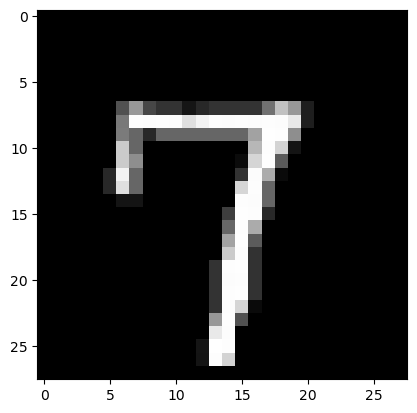

In [373]:
# Let's visualise one row in the data set representing the digit '7'

seven = digits.iloc[6, 1:]
seven = seven.values.reshape(28, 28)  #Reshape the row in a 28 X 28 matrix
plt.imshow(seven, cmap='gray')
plt.show()

In [374]:
# Visualise the 28 X 28 array for the above digit after removing the left, right, top and bottom unnecessary columns
print(seven[5:-5, 5:-5])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  82 152  71  51  51  21  41  51  51  51  51 113 193 152  30   0   0]
 [  0 122 253 252 253 252 223 243 253 252 253 252 253 252 233  30   0   0]
 [  0 123 102  41 102 102 102 102 102 102 102 162 254 253 142   0   0   0]
 [  0 203 102   0   0   0   0   0   0   0   0 183 253 212  20   0   0   0]
 [  0 203 142   0   0   0   0   0   0   0  11 213 254  91   0   0   0   0]
 [ 41 243 102   0   0   0   0   0   0   0  51 252 172  10   0   0   0   0]
 [ 41 223 102   0   0   0   0   0   0   0 214 253 102   0   0   0   0   0]
 [  0  20  20   0   0   0   0   0   0   0 253 252 102   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  62 254 253  41   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 102 253 171   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 163 254  91   0   0   0   0   0   0]
 [  0   0   0   0   0   0

A look at the array shows us that the non-zero cells represent the digit quite clearly

In [376]:
# Summarise the counts of 'label' column to see how many labels of each digit are present
digits.label.astype('category').value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

In [377]:
# Summarise count in terms of percentage 
100*(round(digits.label.value_counts()/digits.shape[0], 4))

label
1    11.15
7    10.48
3    10.36
9     9.97
2     9.95
6     9.85
0     9.84
4     9.70
8     9.67
5     9.04
Name: count, dtype: float64

**Observations:** From the above distribution it's clear that, each digit/label has an approximately 9%-11% fraction in the dataset and thus the **dataset is balanced**. Since SVM requires a balanced dataset, this data ensures we are good to use this dataset for the intended exercise.

In [379]:
# Check for missing values
digits.isnull().sum()

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64

**Observations:** There are no missing values in the dataset. This is expected since we are dealing with images of digits where each pixel
will have a value that says whether that cell represents that particular digit

In [381]:
# Check for average values of features
digits.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


**Observations:** The mean and maximum values of some features (pixels) are 139, 255 etc., whereas most features lie in much lower ranges  (e.g. pixel 0, pixel 1 etc. above).

Hence, there is a need to rescale the features.

## Data Preparation for Model Building

We'll now prepare the dataset for building the model. We'll only use 15% of the data to avoid training process taking a long time.

In [384]:
# Split the data into train and test

# First, separate the target ('label') from the features. X is features set and y is target set
X = digits.iloc[:, 1:]
y = digits.iloc[:, 0]

# Rescale the features in training set using Standardised scale
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# Build the training dataset with train_size=15%.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.15, random_state=101)

# Check if the split has taken place as intended
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6300, 784)
(35700, 784)
(6300,)
(35700,)


In [385]:
# Prepare the test dataset from a separate csv file

test = pd.read_csv("test.csv")

# Check if the columns are in-line with training dataset
test.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Data columns (total 784 columns):
 #    Column    Non-Null Count  Dtype
---   ------    --------------  -----
 0    pixel0    28000 non-null  int64
 1    pixel1    28000 non-null  int64
 2    pixel2    28000 non-null  int64
 3    pixel3    28000 non-null  int64
 4    pixel4    28000 non-null  int64
 5    pixel5    28000 non-null  int64
 6    pixel6    28000 non-null  int64
 7    pixel7    28000 non-null  int64
 8    pixel8    28000 non-null  int64
 9    pixel9    28000 non-null  int64
 10   pixel10   28000 non-null  int64
 11   pixel11   28000 non-null  int64
 12   pixel12   28000 non-null  int64
 13   pixel13   28000 non-null  int64
 14   pixel14   28000 non-null  int64
 15   pixel15   28000 non-null  int64
 16   pixel16   28000 non-null  int64
 17   pixel17   28000 non-null  int64
 18   pixel18   28000 non-null  int64
 19   pixel19   28000 non-null  int64
 20   pixel20   28000 non-null  int64
 21   pixel21   

In [386]:
# Take a look at the test data
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Observations:** Test dataset does not have the target column ('label') as this would be predicted by model

## Model Building

Let's now build the model and tune the hyperparameters.

### Building Linear SVM Model

Let's start with a **linear model** first (i.e. a linear kernel).

In [390]:
# Build an initial SVM model with linear kernel   
linear_model = svm.SVC(kernel='linear')

# Fit the model with training data
linear_model.fit(X_train, y_train)

SVC(kernel='linear')

In [391]:
# Predict the digits using test dataset
digits_pred = linear_model.predict(X_test)
digits_pred[:10]

array([1, 3, 0, 0, 1, 4, 1, 5, 0, 6])

In [392]:
# Evaluate the linear model for accuracy by reviewing the confusion matrix
# C(i, j) represents the number of points known to be in class i, but predicted to be in class j
confusion_mtx = metrics.confusion_matrix(y_true = y_test, y_pred = digits_pred)
confusion_mtx

array([[3392,    0,   19,    5,    8,   27,   31,    3,   11,    2],
       [   0, 3904,   16,   18,    5,    2,    3,    8,   22,    5],
       [  40,   43, 3186,   50,   59,   14,   34,   68,   58,   12],
       [  17,   22,   93, 3267,    7,  172,    4,   29,   52,   25],
       [  16,   10,   24,    5, 3235,    5,   36,   41,    7,  122],
       [  46,   35,   24,  142,   47, 2769,   42,   11,   76,   25],
       [  31,   12,   36,    2,   37,   39, 3302,    2,   23,    0],
       [   6,   24,   38,   26,   47,   12,    3, 3430,    3,  141],
       [  20,   73,   63,  128,   29,  115,   32,   22, 2959,   24],
       [  26,   20,   23,   37,  167,   21,    2,  175,   20, 3079]])

In [393]:
# Measure accuracy of prediction
print(f"Accuracy of Linear Model: {metrics.accuracy_score(y_true=y_test, y_pred=digits_pred): 0.1%}")

Accuracy of Linear Model:  91.1%


In [394]:
# Check digit-wise accuracy
print(metrics.classification_report(y_true=y_test, y_pred=digits_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      3498
           1       0.94      0.98      0.96      3983
           2       0.90      0.89      0.90      3564
           3       0.89      0.89      0.89      3688
           4       0.89      0.92      0.91      3501
           5       0.87      0.86      0.87      3217
           6       0.95      0.95      0.95      3484
           7       0.91      0.92      0.91      3730
           8       0.92      0.85      0.88      3465
           9       0.90      0.86      0.88      3570

    accuracy                           0.91     35700
   macro avg       0.91      0.91      0.91     35700
weighted avg       0.91      0.91      0.91     35700



**Observations:** The accuracy of the linear model at 91.1% is quite good. Digit-wise recall (sensitivity) metric varies from 0.85 (for digit 8) to 0.98 (for digit 1). There is scope for improvement for sensitivity for digits like 8, 9, 5 etc.

In [396]:
# Free up memory by running gc.collect. This will make more memory available
# for computationally heavy SVM model
gc.collect()

2919

### Building Non-Linear SVM Model

We'll now apply a non-linear model with the RBF kernel to see if the model performance improved

In [398]:
# In first rbf kernel we will keep the hyperparameters as default 
rbf_model = svm.SVC(kernel='rbf')
rbf_model.fit(X_train, y_train)

SVC()

In [399]:
# Perform prediction using test dataset
digits_pred = rbf_model.predict(X_test)

# Check accuracy of prediction
print(f"Prediction Accuracy: {metrics.accuracy_score(y_true=y_test, y_pred=digits_pred): 0.2%}")

Prediction Accuracy:  93.41%


The accuracy achieved with a non-linear kernel at 93.4% is slightly higher than a linear one. Let's now do a grid search CV to tune the hyperparameters C and gamma.

### Perform Grid Search Cross-Validation to tune hyperparameters

In [402]:
# Create a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 101)

# Hyperparameters to tune are cost C and the choice of kernel i.e. gamma

hyperparameters = {'C':[1, 10, 100], 
             'gamma': [1e-2, 1e-3, 1e-4]}

# Re-instantiate a rbf model 
rbf_model = svm.SVC(kernel="rbf")

# Create a classifier to perform grid search
grid_search_clf = GridSearchCV(
                        estimator=rbf_model, 
                        param_grid=hyperparameters,
                        cv=folds,
                        scoring='accuracy',
                        return_train_score=True, 
                        verbose=False)

# Fit the classifier with training data
grid_search_clf.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=101, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [1, 10, 100], 'gamma': [0.01, 0.001, 0.0001]},
             return_train_score=True, scoring='accuracy', verbose=False)

In [403]:
# Store the results
results_cv = pd.DataFrame(grid_search_clf.cv_results_)
results_cv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,16.057235,0.668042,3.024911,0.013151,1,0.01,"{'C': 1, 'gamma': 0.01}",0.728571,0.738889,0.726984,...,0.734127,0.008752,9,1.000000,0.999802,1.000000,1.000000,1.000000,0.999960,0.000079
1,4.283577,0.127249,1.901103,0.092230,1,0.001,"{'C': 1, 'gamma': 0.001}",0.924603,0.926190,0.937302,...,0.925714,0.006498,3,0.970040,0.969643,0.969444,0.970040,0.974008,0.970635,0.001702
2,6.179353,0.046976,2.463145,0.025298,1,0.0001,"{'C': 1, 'gamma': 0.0001}",0.900000,0.897619,0.907937,...,0.897937,0.006401,6,0.911310,0.912698,0.908532,0.913690,0.914484,0.912143,0.002094
3,15.670554,0.216474,3.073946,0.126991,10,0.01,"{'C': 10, 'gamma': 0.01}",0.748413,0.753968,0.750000,...,0.753651,0.008498,7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,3.659135,0.077889,1.676123,0.026798,10,0.001,"{'C': 10, 'gamma': 0.001}",0.937302,0.938889,0.942857,...,0.935714,0.007045,2,0.999206,0.999008,0.999405,1.000000,0.999603,0.999444,0.000341
5,3.039970,0.145573,1.635433,0.099673,10,0.0001,"{'C': 10, 'gamma': 0.0001}",0.920635,0.919048,0.935714,...,0.922381,0.006742,4,0.958333,0.957341,0.957937,0.957937,0.960317,0.958373,0.001023
6,17.262550,1.730763,3.155882,0.186092,100,0.01,"{'C': 100, 'gamma': 0.01}",0.748413,0.753968,0.750000,...,0.753651,0.008498,7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,3.779378,0.094877,1.695639,0.041738,100,0.001,"{'C': 100, 'gamma': 0.001}",0.935714,0.939683,0.945238,...,0.936190,0.007655,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,2.297610,0.042849,1.337525,0.037319,100,0.0001,"{'C': 100, 'gamma': 0.0001}",0.914286,0.923810,0.928571,...,0.920159,0.005714,5,0.996230,0.995437,0.995635,0.995238,0.996230,0.995754,0.000409


### Perform Visualisation of the Results

We will now create plots of model results against C and gamma in order to select optimised values of hyperparameters

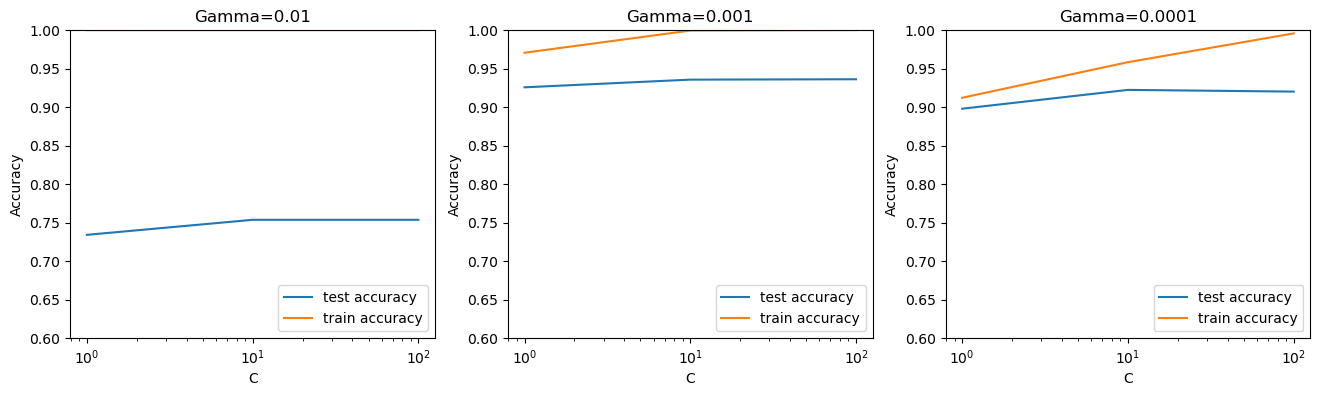

In [405]:
# Convert C to numeric type for plotting on x-axis
results_cv['param_C'] = results_cv['param_C'].astype('int')

# Size the plot
plt.figure(figsize=(16,4))

# Subplot 1/3 for gamma=0.01
plt.subplot(131)
gamma_01 = results_cv[results_cv['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='lower right')
plt.xscale('log')

# Subplot 2/3 for gamma=0.001
plt.subplot(132)
gamma_001 = results_cv[results_cv['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='lower right')
plt.xscale('log')


# Subplot 3/3 for gamma=0.0001
plt.subplot(133)
gamma_0001 = results_cv[results_cv['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='lower right')
plt.xscale('log')

plt.show()

**Observations**:
In the above plots, higher to lower gamma values are plotted from left to right.

The observations are:

- At very high gamma (0.01), the model is achieving 100% accuracy on the training data, though the test score is quite low (<75%). So, the model is overfitting.

- At gamma=0.001, the training and test scores are comparable at around C=1, though the model starts to overfit at higher values of C

- At gamma=0.0001, the model does not overfit till C=10 but starts showing signs of overfitting at C=100. Also, the training and test scores are slightly lower than at gamma=0.001.

So, it seems that the best combination is gamma=0.001 and C=1 (the plot in the middle), which gives the highest test accuracy (~92%) while avoiding overfitting.

We will now finetune C further by auto-tunning using RandomisedSearchCV.

### Perform Randomised Search Cross Validation of Model

The range to be provided for C and gamma to auto-tuner is around the figure we arrived at through mannual plotting i.e. C=1 and gamme = 0.001

In [408]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 101)

# Specify hyperparameter distributions for auto-tuning of parameters
param_dist = {
    'C': uniform(0.5, 5),  # Range of C values to explore
    'gamma': uniform(0.0005, 0.001),  # Range of gamma values to explore
}


# Re-instantiate model
rbf_model = svm.SVC(kernel="rbf")

# set up RandomizedSearchCV()

random_cv = RandomizedSearchCV(
    estimator=rbf_model,
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to try
    cv=folds,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPU cores
    scoring='accuracy',  # Metric to optimize
    verbose=False,
    return_train_score=True
)

# fit the model
random_cv.fit(X_train, y_train) 

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=101, shuffle=True),
                   estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x15b1b53d0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x15ae66ad0>},
                   return_train_score=True, scoring='accuracy', verbose=False)

### Finalise the Model

We will now build the final model with chosen hyperparameters.

In [410]:
# View the best parameters returned by Randomised Search model
random_cv.best_params_

{'C': 5.208772594856612, 'gamma': 0.0014039372237396003}

In [411]:
# Build the final model using optimal hyperparameters
best_C = random_cv.best_params_.get('C')
best_gamma = random_cv.best_params_.get('gamma')

final_model = svm.SVC(
            kernel='rbf', 
            C=best_C, 
            gamma=best_gamma, 
            verbose=False)

# Fit the final model
final_model.fit(X_train, y_train)

SVC(C=5.208772594856612, gamma=0.0014039372237396003)

So the most optimum parameters for the model are: C=5.2 and gamma=0.001

## Evaluating Model

We will now evaluate the final model using test data to check its performance

In [414]:
# Predict the digits using test data set
digits_pred = final_model.predict(X_test)

In [415]:
# View the parameters for the final model
print('b = ', final_model.intercept_)
print('\n Indices of support vectors = ', final_model.support_)
print('\n Support vectors = ', final_model.support_vectors_)
print('\n Number of support vectors for each class = ', final_model.n_support_)
print('\n Coefficients of the support vector in the decision function = ', np.abs(final_model.dual_coef_))


b =  [ 0.37407584 -0.5701891  -0.45424878  0.01793183 -0.25743174 -0.52507019
 -0.5520637   0.03961003 -0.26591704 -0.81208554 -0.73844294 -0.22913699
 -0.58762253 -0.70990885 -0.78909948 -0.25547339 -0.59615125  0.19853724
  0.61002341  0.41917799  0.08215197  0.0256975   0.6082428   0.35197339
  0.47107231  0.26761224 -0.10771136 -0.1644308   0.54399221  0.19473228
 -0.26459566 -0.54082427 -0.63353932 -0.06970359 -0.46583726 -0.33224663
 -0.38456132  0.38533718 -0.04457769 -0.05149118  0.51626694  0.26263554
  0.59572258  0.41562015 -0.32441763]

 Indices of support vectors =  [  11   14   22 ... 6201 6229 6251]

 Support vectors =  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

 Number of support vectors for each class =  [232 162 352 372 287 340 285 355 338 354]

 Coefficients of the support vector in the decision function =  [[0.50929764 0.22082908 0.         ... 0.1882148

In [416]:
print(f"No. of Intercepts: {final_model.intercept_.shape[0]}")
print(f"No. of Support Vectors: {final_model.support_.shape[0]}")
print(f"Shape of Support Vectors: {final_model.support_vectors_.shape}")
print("Digit-wise No. of Support Vectors: ")
for i, n in enumerate(final_model.n_support_):
    print("{0} = {1}; ".format(i, n), end='')
print(f"\nShape of Dual Coefs: {final_model.dual_coef_.shape}")
print(f"Degree of Polynomial: {final_model.degree}")

No. of Intercepts: 45
No. of Support Vectors: 3077
Shape of Support Vectors: (3077, 784)
Digit-wise No. of Support Vectors: 
0 = 232; 1 = 162; 2 = 352; 3 = 372; 4 = 287; 5 = 340; 6 = 285; 7 = 355; 8 = 338; 9 = 354; 
Shape of Dual Coefs: (9, 3077)
Degree of Polynomial: 3


In [417]:
# Review the Confusion Matrix 
confusion_matrix = metrics.confusion_matrix(y_true = y_test, y_pred = digits_pred)
print(confusion_matrix)

# Review accuracy metric
print(f"\n Model Accuracy: {metrics.accuracy_score(y_true=y_test, y_pred=digits_pred): 0.2%} \n")

# Check digit-wise accuracy
print("Digit-wise Accuracy:")
print(metrics.classification_report(y_true=y_test, y_pred=digits_pred))


[[3407    0   24    1    4   11   35    4   10    2]
 [   0 3912   25   14    6    2    5    9    5    5]
 [  16   14 3352   36   24    6   25   54   28    9]
 [   4    4  106 3402    2   74    4   31   43   18]
 [   4    8   54    2 3269   10   29   27    4   94]
 [  18    7   48   73   12 2954   46   14   25   20]
 [  17    5   66    1    8   24 3347    3   13    0]
 [   5   20   82   14   26    4    0 3508    2   69]
 [  10   26   69   49   13   61   14   20 3182   21]
 [  12    6   55   26   70    9    0  102   22 3268]]

 Model Accuracy:  94.12% 

Digit-wise Accuracy:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3498
           1       0.98      0.98      0.98      3983
           2       0.86      0.94      0.90      3564
           3       0.94      0.92      0.93      3688
           4       0.95      0.93      0.94      3501
           5       0.94      0.92      0.93      3217
           6       0.95      0.96      0.

#### Conclusion

The accuracy of the final model, using the best parameters suggested by Randomised Search model, has improved the result by more than 2% at 94.1%. The sensitivity metric for all digits has surpassed 90% which is a significant improvement over linear model.

Note that the results can be significantly increased further by using the entire training data of 42,000 images instead of the 15% that we have used in this exercise. 

**In more technical terms**, here are some of the relevant attributes of the model:

- This is a $n$-class classification problem where $n$ = 10 ($0 - 9$ digits).
- The SVM has been built using a one-vs-one (`ovr`) approach. 

- We have trained $\frac{n(n-1)}{2}$ (= $45$) binary classifiers for each pair of classes.

- Each binary classifier $(i, j)$ makes a decision $f_{ij}(\mathbf{x}) $.

- The final class is determined based on the aggregation of these decisions.

<br>
The decision function for each pair $(i, j)$ is:

$$ f_{ij}(\mathbf{x}) = \sum_{k=1}^{N_{ij}} \alpha_k^{ij} y_k^{ij} K(\mathbf{x}_k^{ij}, \mathbf{x}) + b_{ij} $$

where:
- $N_{ij}$ is the number of support vectors for the binary classifier separating classes $i$ and $j$. Total Support Ventors = 3077
- $\alpha_k^{ij}$ are the learned dual coefficients for the support vectors. **Total dual coefficients = 9 * 3077**. Each support vector has a dual coefficient in each of the $n - 1$ classifiers comparing the class of the Vector against another class. Note that some, but not all, of these dual coefficients, may be zero. 
- $y_k^{ij}$ are the class labels of the support vectors.
- $K(\mathbf{x}_i, \mathbf{x})$ is the kernel function, specifically the RBF kernel in this case.
- $b_{ij}$ is the bias term.
- $\mathbf{x}_k^{ij}$ are the support vectors.
- $\mathbf{x}$ is the input feature vector to be classified.

The RBF kernel function is defined as:

$$ K(\mathbf{x}_i, \mathbf{x}) = \exp\left(-\gamma \|\mathbf{x}_i - \mathbf{x}\|^2\right) $$

where:
- $\gamma$ is a parameter that defines the spread of the RBF kernel.
